## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants

import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [4]:
# from exoplanet.eu catalog: https://exoplanet.eu/catalog/lp_714_47_b--7534/#publication_21546
# Dreizler et al 2020: https://www.aanda.org/articles/aa/full_html/2020/12/aa38016-20/aa38016-20.html
# exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=714.47
TIC_ID = 70899085

period_tess = ufloat(4.0520368, 0.0000044)
epoch_tess = ufloat(2459196.115341, 0.0005086)
duration_tess = 1.5605127851947

mass_pub = ufloat(0.0969, 0.0047)*u.M_jup.to(u.M_earth)
period_pub = ufloat(4.052037, 4e-06) # days
e_pub = ufloat(0.04, 0.02)
K_pub = ufloat(17.6, 0.8) # m/s
epoch_pub = ufloat(0.38421+58438, 0.00025)
radius_pub = ufloat(4.7, 0.3) # R_earth

stteff_pub = ufloat(3950, 51)
strad_pub = ufloat(0.584, 0.016)
stmass_pub = ufloat(0.59, 0.02)

## Read RVs

In [5]:
spirou = pd.read_table('./data/toi442/lbl2_TOI442_GL846_jun24.rdb', sep=None, engine='python', header=0)
others = pd.read_table('./data/toi442/other_instruments.rdb', sep='\s+', engine='python', header=0)

# substract 2400000 to the BJD time of the other instruments
others['BJD'] = others['BJD'] - 2400000
others.drop('id', axis=1, inplace=True)
# change the name of the column to match the SPIROU data
others = others.rename(columns={'RV': 'vrad', 'e': 'svrad', 'BJD': 'rjd', 'Inst': 'inst'})    
rv_inst_names = ['SPIROU', 'CARMENES-VIS', 'CARMENES-NIR', 
                 'ESPRESSO', 'HIRES', 'iSHELL', 'PFS']
star_name = 'TOI 442'

In [6]:
others.head()

,rjd,vrad,svrad,inst
0,58534.32389,13.26,3.18,CARMENES-VIS
1,58535.33280,2.02,2.36,CARMENES-VIS
2,58537.32475,-10.56,3.16,CARMENES-VIS
3,58538.31622,9.09,2.04,CARMENES-VIS
4,58539.36166,-6.18,2.78,CARMENES-VIS


In [7]:
others.inst.unique()

array(['CARMENES-VIS', 'CARMENES-NIR', 'ESPRESSO', 'HIRES', 'iSHELL',
       'PFS'], dtype=object)

In [8]:
# d2v is "differential line width", an activity indicator. 
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line, 
# but as far as I know no one tries to use that product yet
spirou.head()

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,local_file_name,plot_date,dW,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
0,58759.099352,-7397.056429,4.791139,-99263.497653,11644.229235,-5.102270e+07,2.153491e+07,2446035o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18171.591738,-5.504337e+05,...,-7332.886397,27.557326,-7398.521960,39.073341,-7533.328489,31.390904,-7414.073774,16.080845,-7378.426394,34.101821
1,58761.991347,-7374.058768,4.004270,266349.639006,9800.822834,-3.408132e+07,1.811593e+07,2446427o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18174.483542,1.476956e+06,...,-7339.096117,24.722595,-7525.564670,34.733570,-7465.579766,25.464413,-7390.713345,13.336327,-7388.354465,27.433725
2,58762.982476,-7406.452477,4.048727,-137604.963106,9870.734210,-4.219595e+07,1.823598e+07,2446609o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18175.474610,-7.630439e+05,...,-7374.703480,25.813091,-7450.803841,35.681725,-7398.337727,25.876885,-7413.938904,13.314013,-7378.851492,27.772346
3,58766.039346,-7379.743134,3.960176,269909.006920,9723.162864,-3.373430e+07,1.798324e+07,2447239o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18178.531309,1.496693e+06,...,-7328.603792,27.315696,-7473.612060,39.272133,-7420.521746,26.299848,-7405.232991,14.143986,-7361.538647,28.903161
4,58770.122279,-7364.167764,3.919292,285230.149841,9605.214471,-4.389580e+07,1.779629e+07,2447827o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18182.614029,1.581652e+06,...,-7316.600562,25.338153,-7500.274182,36.295045,-7359.992039,26.988041,-7370.126919,14.486527,-7296.533434,32.479495


In [9]:
# substract the mean of all the RVs per instrument, convert spirou to m/s
others['vrad'] = others.groupby('inst')['vrad'].transform(lambda x: x - x.mean())
spirou['vrad'] = (spirou['vrad'] - spirou['vrad'].mean())

### Outliers

Text(0.5, 0, 'RV [km/s]')

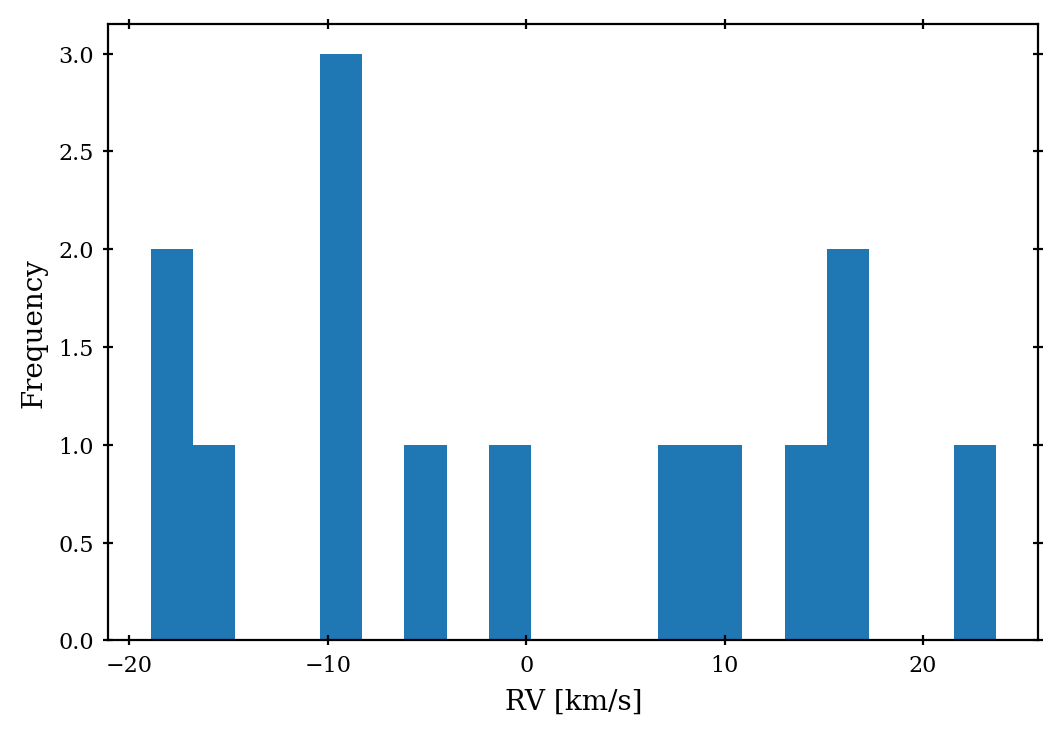

In [10]:
# histograma
spirou.vrad.plot(kind='hist', bins=20)
plt.xlabel('RV [km/s]')

<Axes: ylabel='Frequency'>

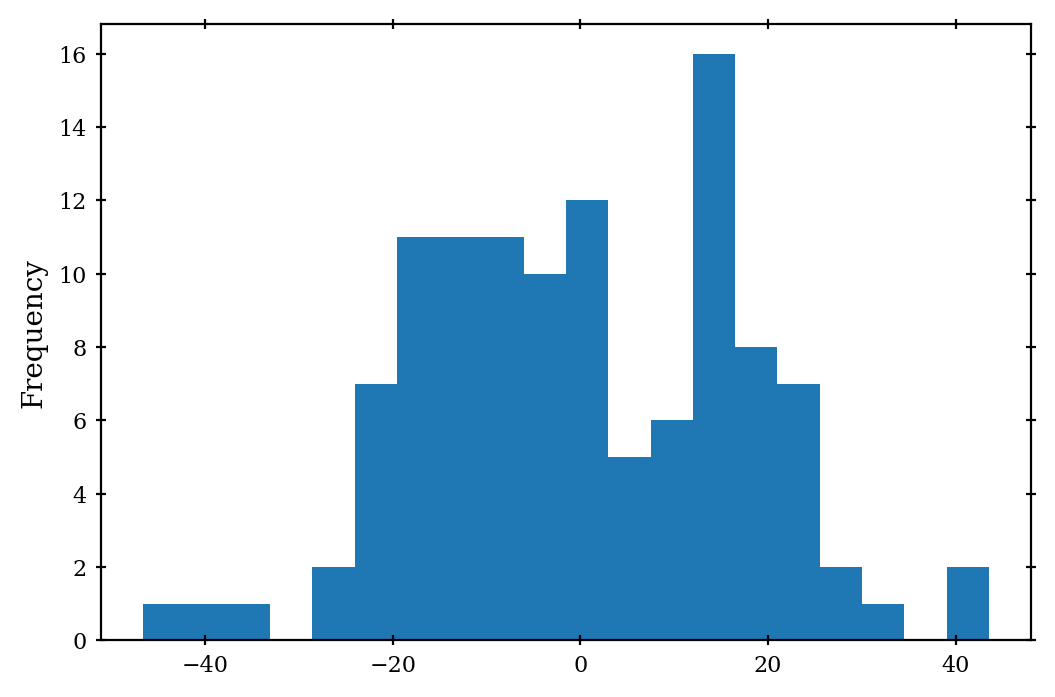

In [11]:
others.vrad.plot(kind='hist', bins=20)

<Axes: >

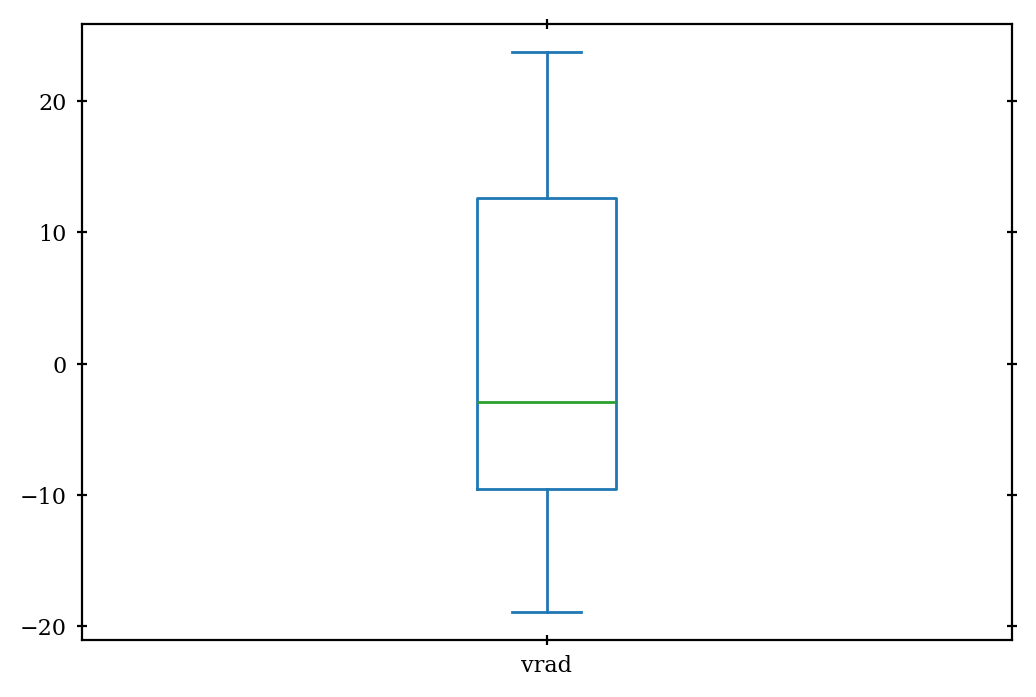

In [12]:
# boxplot
spirou.vrad.plot(kind='box')

<Axes: >

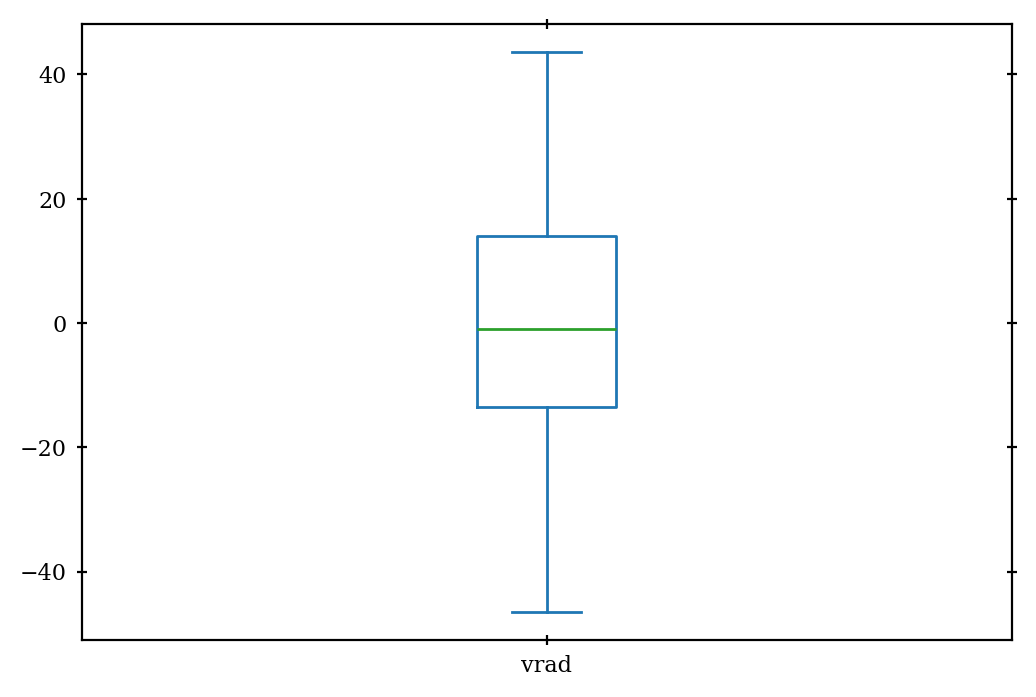

In [13]:
others.vrad.plot(kind='box')

In [14]:
# # detect outliers using iqr
# q1 = spirou.vrad.quantile(0.25)
# q3 = spirou.vrad.quantile(0.75)
# iqr = q3 - q1
# mask = (spirou.vrad < (q1 - 1.5 * iqr)) | (spirou.vrad > (q3 + 1.5 * iqr))

# # filter outliers
# spirou = spirou[~mask]

# # substract the mean of the radial velocity
# spirou['vrad'] = spirou['vrad'] - spirou['vrad'].mean()

### Plot RVs

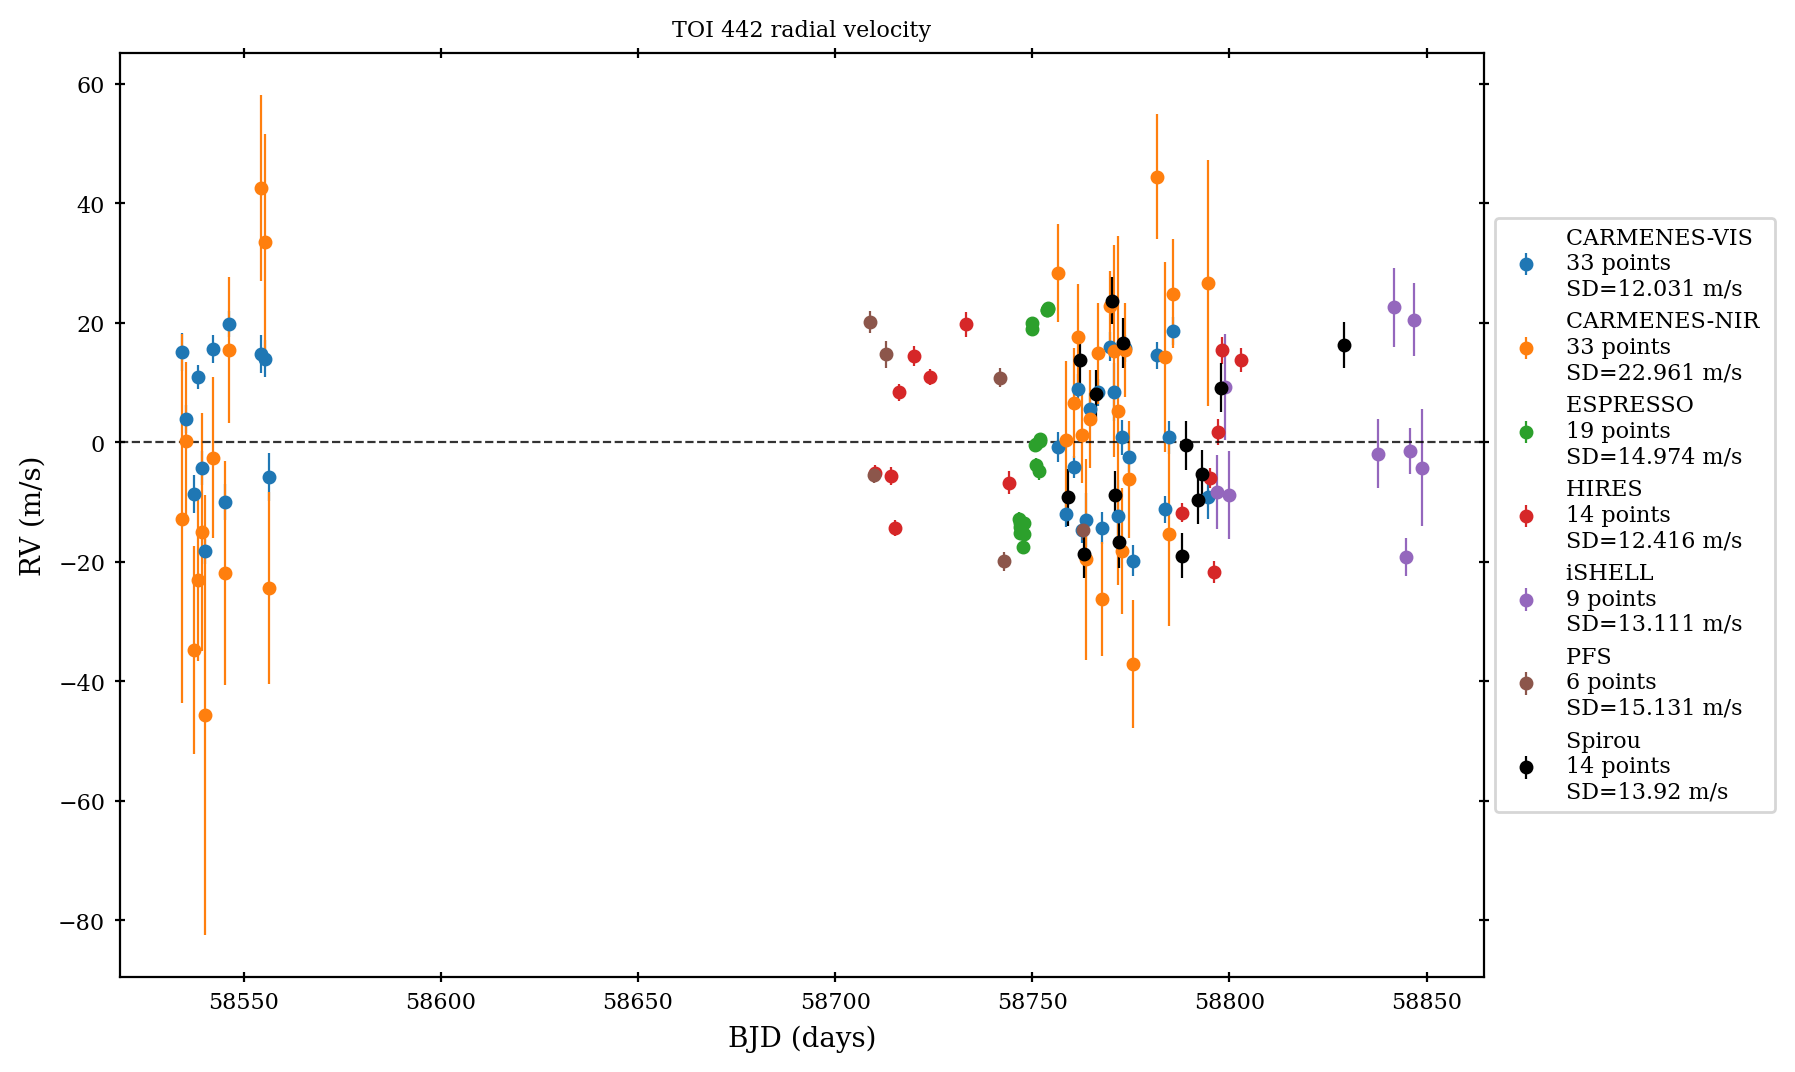

In [15]:
fig, ax = plt.subplots(figsize=(11, 6))

for inst in others.inst.unique():
    mask = others.inst == inst
    ax.errorbar(others[mask].rjd, others[mask].vrad-others.vrad.median(), yerr=others[mask].svrad, fmt='o', label=f'{inst} \n{len(others[mask])} points\nSD={np.round(np.std(others[mask].vrad),3)} m/s', markersize=4, elinewidth=0.8)
ax.errorbar(spirou['rjd'], spirou['vrad'], yerr=spirou['svrad'], fmt='o', label=f'Spirou \n{len(spirou)} points\nSD={np.round(np.std(spirou.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='k')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.8)
# set legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'{star_name} radial velocity')
ax.set_xlabel('BJD (days)')
ax.set_ylabel('RV (m/s)')
plt.show()

In [16]:
# drop the first season of CARMENES-NIR
mask = (others.inst == 'CARMENES-NIR') & (others.rjd < 58600)
others = others[~mask]

In [17]:
spirou['inst'] = 'SPIROU'
# prepare the data for the model
t_rv = np.concatenate((spirou['rjd'], others['rjd']))
rv = np.concatenate((spirou['vrad'], others['vrad']))
rv_err = np.concatenate((spirou['svrad'], others['svrad']))
rv_inst = np.concatenate((spirou['inst'], others['inst']))
# map inst names to integers
rv_inst_id = np.array([rv_inst_names.index(inst) for inst in rv_inst])

inds = np.argsort(t_rv)
t_rv = np.ascontiguousarray(t_rv[inds], dtype=np.float64)
rv = np.ascontiguousarray(rv[inds], dtype=np.float64)
rv_err = np.ascontiguousarray(rv_err[inds], dtype=np.float64)
rv_inst_id = np.ascontiguousarray(rv_inst_id[inds], dtype=int)
rv_inst = np.ascontiguousarray(rv_inst[inds], dtype='S')

num_rv_inst = len(rv_inst_names)

In [18]:
np.unique(rv_inst) 

array([b'CARMENES-NIR', b'CARMENES-VIS', b'ESPRESSO', b'HIRES', b'PFS',
       b'SPIROU', b'iSHELL'], dtype='|S12')

In [19]:
np.unique(rv_inst_id)

array([0, 1, 2, 3, 4, 5, 6])

In [20]:
others.groupby('inst')['rjd'].count()

inst
CARMENES-NIR    21
CARMENES-VIS    33
ESPRESSO        19
HIRES           14
PFS              6
iSHELL           9
Name: rjd, dtype: int64

### GLS analysis

In [21]:
series = ['spirou rvs', 'spirou dlw',  'carmenes-nir', 'carmenes-vis', 'espresso', 'hires', 'ishell', 'all rvs', 'window function']
carmenes_nir_mask = rv_inst == b'CARMENES-NIR'
carmenes_vis_mask = rv_inst == b'CARMENES-VIS'
espresso_mask = rv_inst == b'ESPRESSO'
hires_mask = rv_inst == b'HIRES'
ishell_mask = rv_inst == b'iSHELL'

lg = [ls(spirou.rjd, spirou.vrad, spirou.svrad),
      ls(spirou.rjd, spirou.d2v, spirou.sd2v),
      ls(t_rv[carmenes_nir_mask], rv[carmenes_nir_mask], rv_err[carmenes_nir_mask]),
      ls(t_rv[carmenes_vis_mask], rv[carmenes_vis_mask], rv_err[carmenes_vis_mask]),
      ls(t_rv[espresso_mask], rv[espresso_mask], rv_err[espresso_mask]),
      ls(t_rv[hires_mask], rv[hires_mask], rv_err[hires_mask]),
      ls(t_rv[ishell_mask], rv[ishell_mask], rv_err[ishell_mask]),
      ls(t_rv, rv, rv_err),
      ls(t_rv, np.ones(len(t_rv)), fit_mean=False, center_data=False)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

Text(0, 0.5, 'Power')

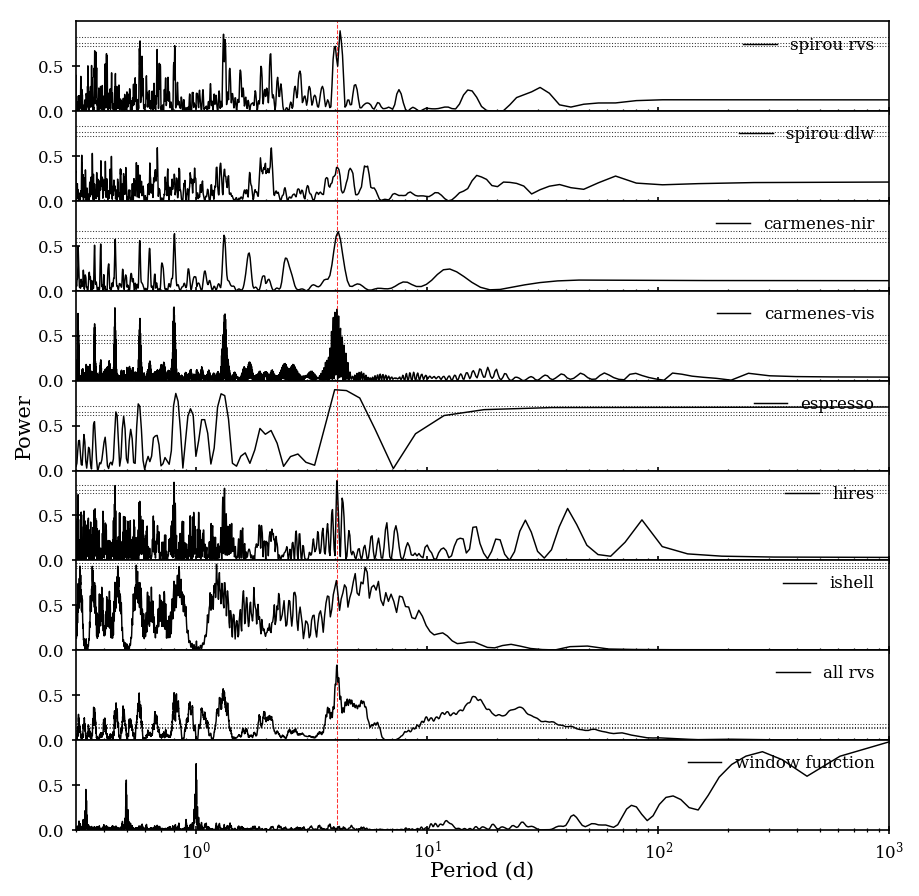

In [22]:
# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,7), dpi=150)
#fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.5])
    ax[i].tick_params(which='both', top=False, right=False)
    if name == "window function":
        ax[i].set_ylim(0, 1)
        ax[i].set_yticks([0.0, 0.5])
    else:
        ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)

## Read LCs

In [23]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=70899085

In [24]:
lk.search_targetpixelfile('TIC 70899085')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,70899085,0.0
1,TESS Sector 32,2020,SPOC,120,70899085,0.0
2,TESS Sector 05,2018,TESS-SPOC,1800,70899085,0.0
3,TESS Sector 32,2020,TESS-SPOC,600,70899085,0.0


In [25]:
search = lk.search_lightcurve('TIC 70899085')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,70899085,0.0
1,TESS Sector 32,2020,SPOC,120,70899085,0.0
2,TESS Sector 05,2018,TESS-SPOC,1800,70899085,0.0
3,TESS Sector 32,2020,TESS-SPOC,600,70899085,0.0
4,TESS Sector 05,2018,QLP,1800,70899085,0.0
5,TESS Sector 32,2020,QLP,600,70899085,0.0
6,TESS Sector 05,2018,TASOC,120,70899085,0.0
7,TESS Sector,2018,DIAMANTE,1800,70899085,0.0
8,TESS Sector 05,2018,GSFC-ELEANOR-LITE,1800,70899085,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

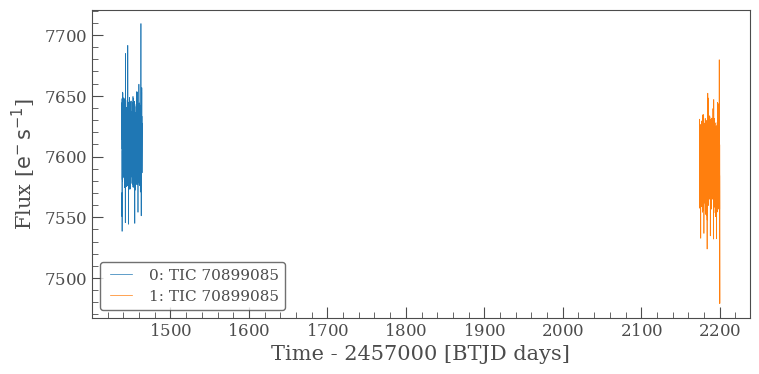

In [26]:
search[search.author == 'SPOC'].download_all().plot()

In [27]:
# download both sectors and stitch them together
lc_file = lk.search_lightcurve('TIC 70899085', author='SPOC', exptime=120).download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

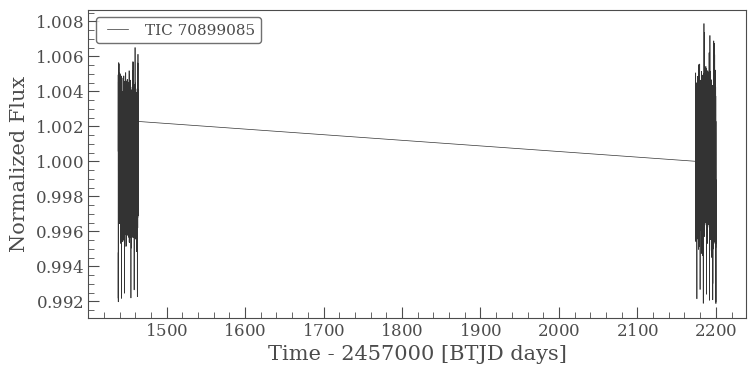

In [28]:
lc.plot()

(1437.0, 1464.0)

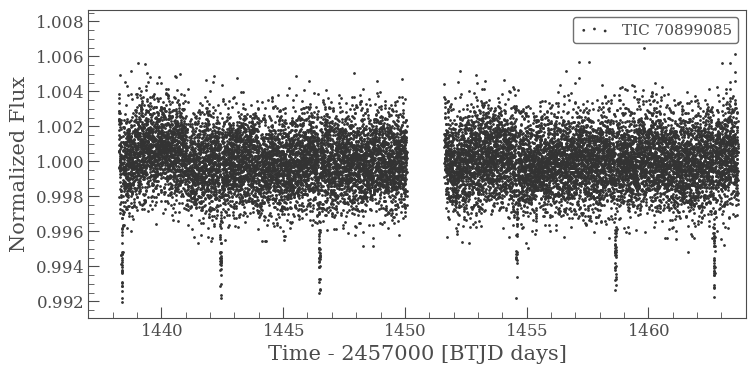

In [29]:
# sector 5
lc.scatter()
plt.xlim(1437, 1464)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

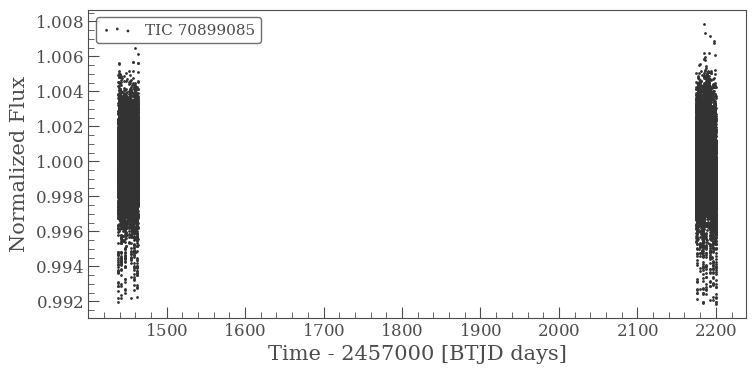

In [30]:
# sector 32
lc.scatter()
#plt.xlim(2199, 2201)

In [31]:
# lets remove that last transit
lc = lc.truncate(after=2199.50)

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

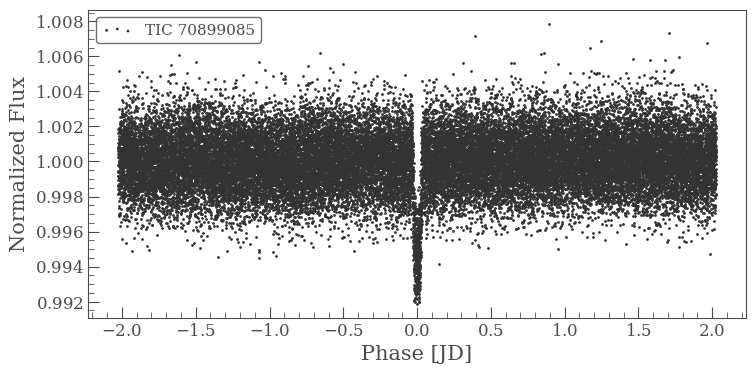

In [32]:
lc.fold(period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter()

In [33]:
time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value

# get the exptimes
with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr = np.ascontiguousarray(1e3 * flux_err, dtype=np.float64) 

### TESS TLS

In [34]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

In [35]:
period_tess.nominal_value

4.0520368

In [36]:
info = catalog_info(TIC_ID=TIC_ID)
tls = transitleastsquares(time, flux, flux_err)
results = tls.power(u=list(info[0]))
# results = tls.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
#                    M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
#                    u=list(info[0]), period_min=period_tess.nominal_value-0.1, period_max=period_tess.nominal_value+0.1)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 61 durations
Searching 34136 data points, 94828 periods from 0.602 to 380.623 days
Using all 12 CPU threads


100%|██████████| 94828/94828 periods | 14:15<00:00


Searching for best T0 for period 4.05213 days


100%|██████████| 6031/6031 [00:03<00:00, 1910.63it/s]
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/transitleastsquares/main.py:411: UserWarning: 176 of 188 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [37]:
# full search: 4.052130273401449 1438.3755697600861 0.004183844268111227 0.9957480251776143 52.50609503212815
print(results.period, results.T0, results.duration, results.depth, results.SDE)

4.052130273401449 1438.3755697600861 0.004183844268111227 0.9957480251776143 52.50609503212815


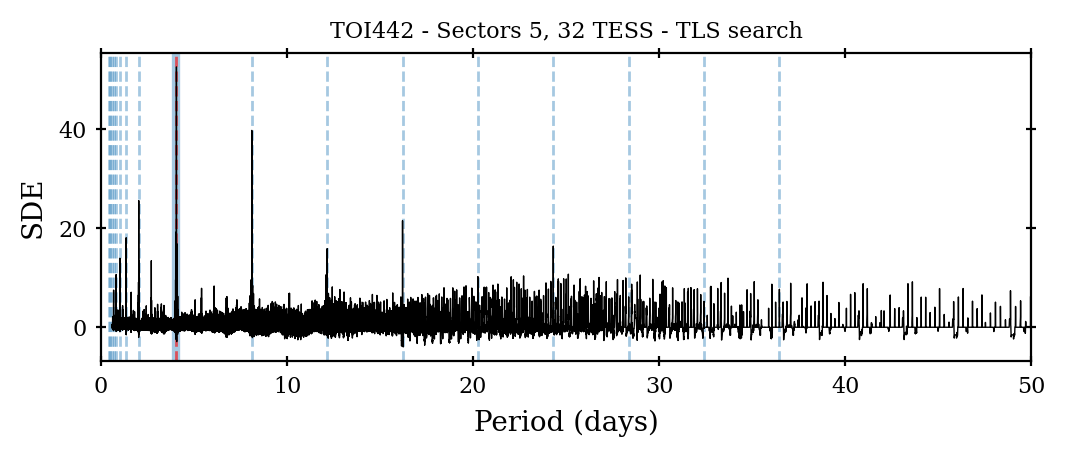

In [38]:
plt.figure(figsize=(6, 2))
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
ax.axvline(period_tess.nominal_value, ls='--', alpha=0.6, lw=1, color='red')
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, 50)
plt.title('TOI442 - Sectors 5, 32 TESS - TLS search')
plt.savefig('tls-toi442.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

Text(0, 0.5, 'Relative flux')

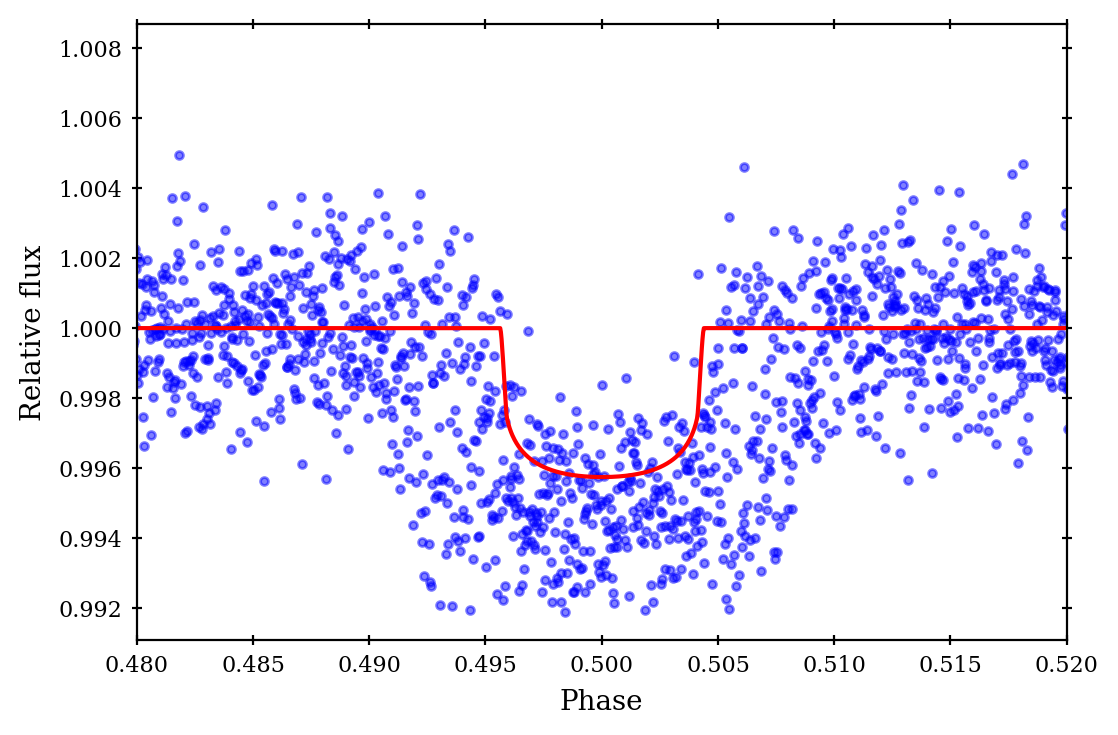

In [39]:
# results phase folded
plt.figure()
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=8, alpha=0.5, zorder=2)
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux')

In [40]:
results.duration*20

0.08367688536222453

In [41]:
duration_tess/24

0.06502136604977916

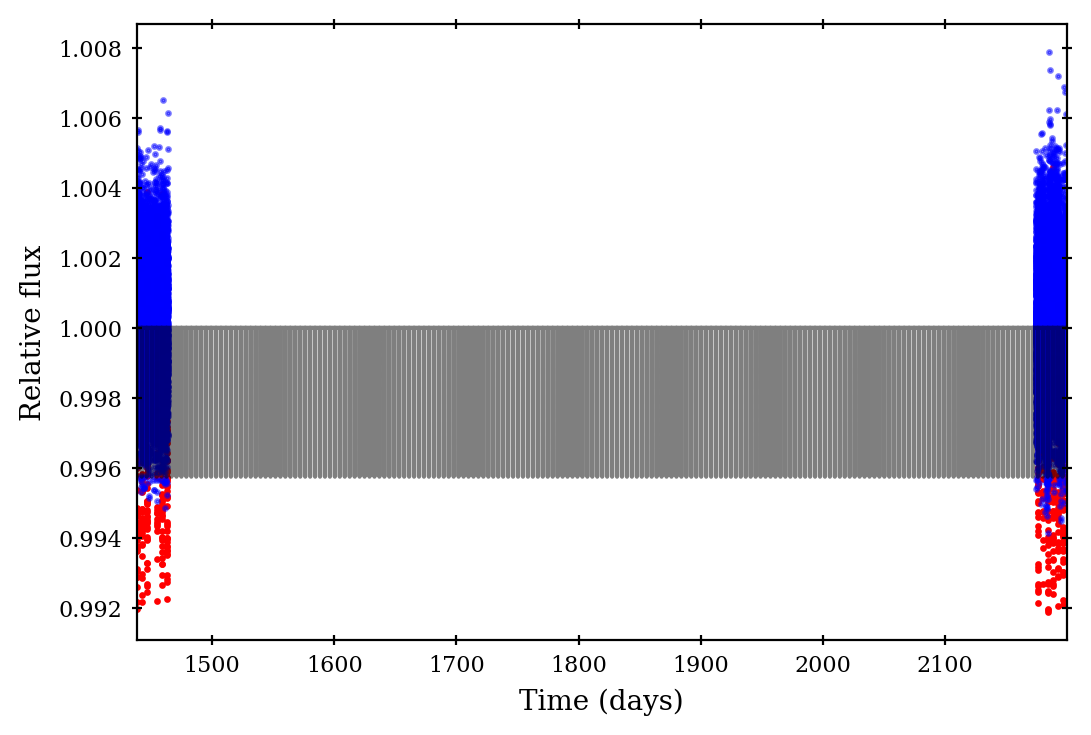

In [42]:
# complete light curve
plt.figure()
in_transit = transit_mask(time, results.period, results.duration*20, results.T0)
plt.scatter(time[in_transit], flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(time[~in_transit], flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(time.min(), time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
#plt.xlim(1454,1455)

In [43]:
print('mean depth:', (1-np.nanmean(results.transit_depths))*1e3, 'ppt')

mean depth: 5.331212447749256 ppt


Period 4.05213 d at T0= 1438.3755697600861
The number of transits with intransit data points 12
The number of transits with no intransit data points 176
Transit depth 0.99575 (at the transit bottom)
Transit duration (hours) 0.10041


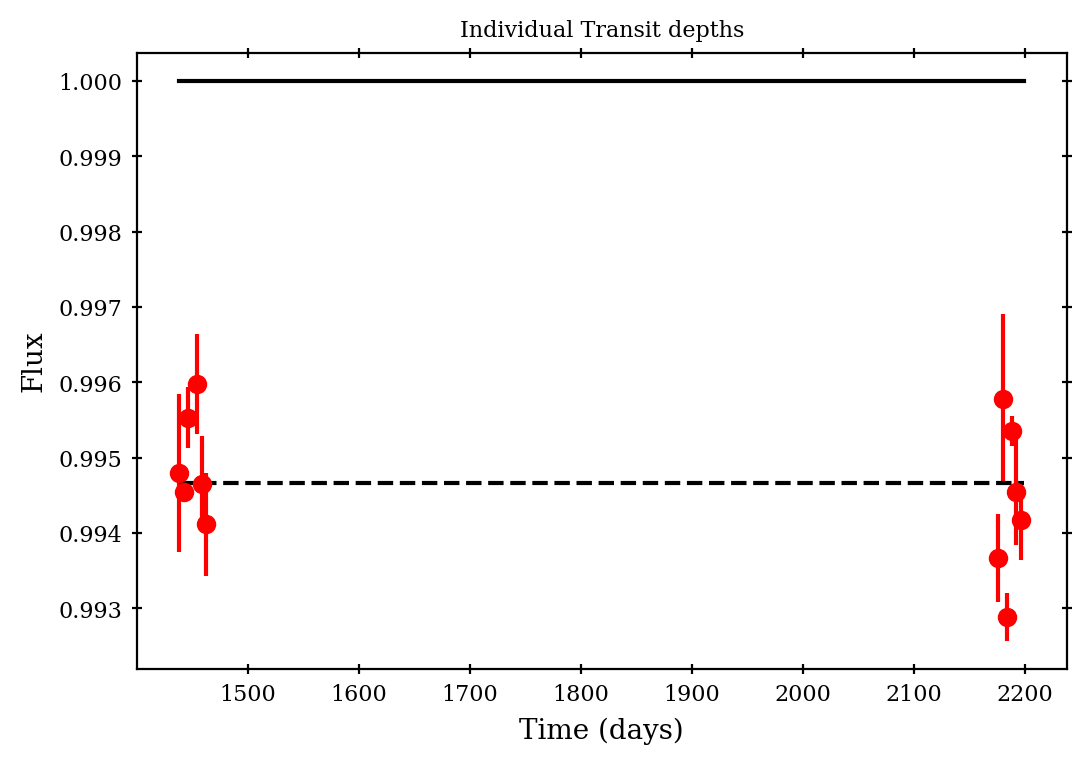

In [44]:
print('Period', format(results.period, '.5f'), 'd at T0=', results.T0)
# print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
# print('Number of data points during each unique transit', results.per_transit_count)
print('The number of transits with intransit data points', results.distinct_transit_count)
print('The number of transits with no intransit data points', results.empty_transit_count)
print('Transit depth', format(results.depth, '.5f'), '(at the transit bottom)')
print('Transit duration (hours)', format(results.duration*24, '.5f'))
# print('Transit depths (mean)', results.transit_depths)
# print('Transit depth uncertainties', results.transit_depths_uncertainties)

plt.figure()
plt.errorbar(
    results.transit_times,
    results.transit_depths,
    yerr=results.transit_depths_uncertainties,
    fmt='o', color='red')
plt.plot(
    (time.min(), time.max()),
    (np.nanmean(results.transit_depths), np.nanmean(results.transit_depths, dtype=np.float64)),
     color='black', linestyle='dashed')
plt.plot((time.min(), time.max()), (1, 1), color='black')
plt.xlabel('Time (days)')
plt.ylabel('Flux');
plt.title('Individual Transit depths')
plt.savefig('transit_depths-toi442.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [45]:
# search for second planet
tls_2 = transitleastsquares(time[~in_transit], flux[~in_transit], flux_err[~in_transit])
results2 = tls_2.power(u=list(info[0]))

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 61 durations
Searching 33434 data points, 94828 periods from 0.602 to 380.623 days
Using all 12 CPU threads


 30%|██▉       | 27987/94828 periods | 03:11<07:36

KeyboardInterrupt: 

 30%|██▉       | 27991/94828 periods | 03:25<07:36

In [310]:
print(results2.period, results2.T0, results2.duration, results2.depth, results2.SDE)
# full search 2: 26.16385372279952 1450.5808999733417 0.06890292441317561 0.9988451561346696 11.374034403312262
# only two transits, one in a border of the sector. it's nothing.

26.16385372279952 1450.5808999733417 0.06890292441317561 0.9988451561346696 11.374034403312262


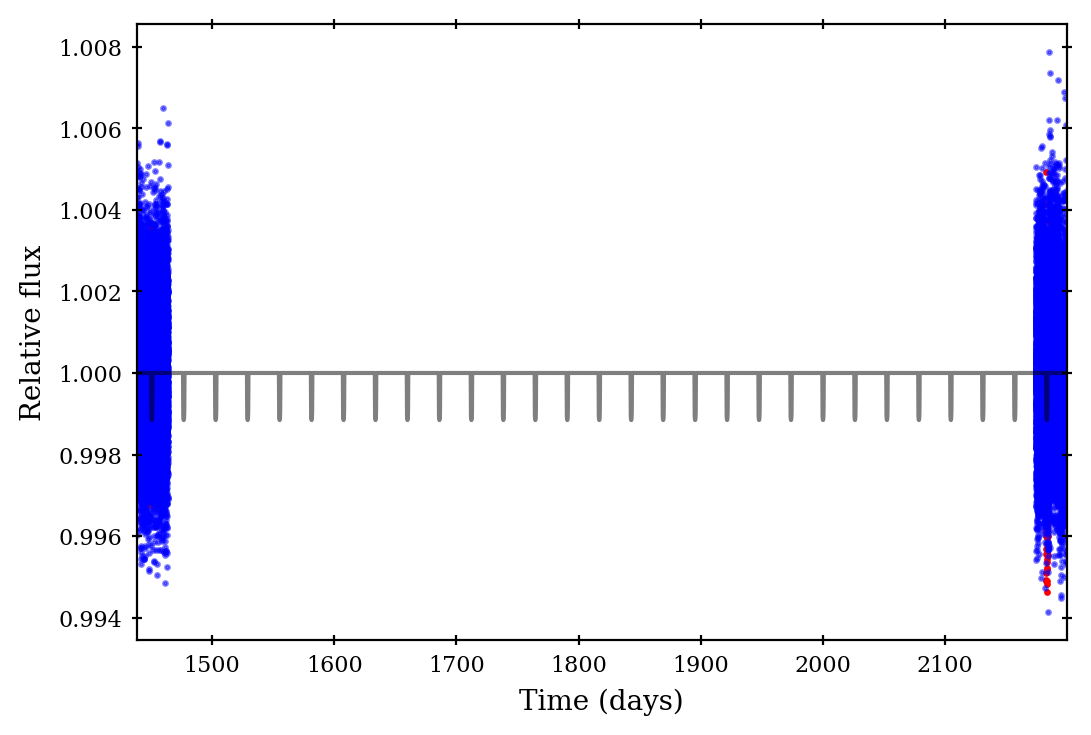

In [319]:
# complete light curve
plt.figure()
in_transit2 = transit_mask(time[~in_transit], results2.period, results2.duration*20, results2.T0)
plt.scatter(time[~in_transit][in_transit2], flux[~in_transit][in_transit2], color='red', s=2, zorder=0)
plt.scatter(time[~in_transit][~in_transit2], flux[~in_transit][~in_transit2], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results2.model_lightcurve_time, results2.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(time[~in_transit].min(), time[~in_transit].max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
# sector 32
#plt.xlim(2172,2202)
# sector 5
#plt.xlim(1437,1465)

### GLS TESS Analysis

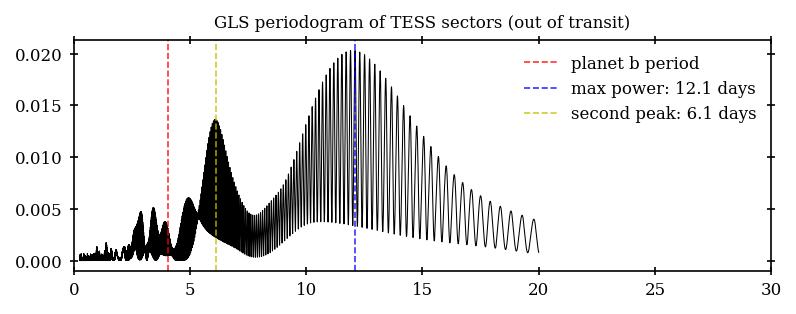

In [322]:
# first remove in-transit points from results 1
lslc = ls(time[~in_transit], flux[~in_transit], flux_err[~in_transit])

lc_freq, lc_power = lslc.autopower(minimum_frequency=0.05, maximum_frequency=4, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.5)
ax.set_xlim(0,30)
#ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.8, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.8, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.axvline(6.1, color='y', linestyle='--', linewidth=0.8, alpha=0.8, 
           label='second peak: '+str(np.round(6.1,2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title('GLS periodogram of TESS sectors (out of transit)')
plt.savefig('gls-toi442.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

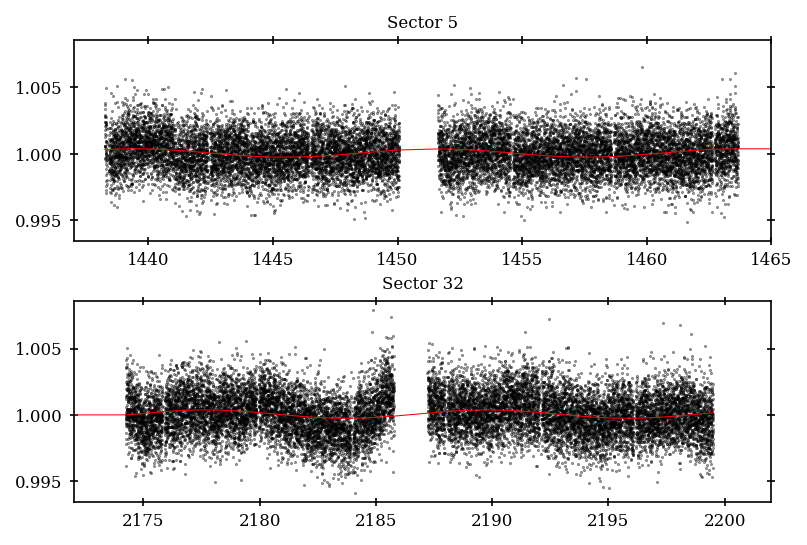

In [323]:
y_fit = lslc.model(time[~in_transit], lc_freq[np.argmax(lc_power)])
fig, ax = plt.subplots(2, 1, figsize=(6,4), dpi=150)
fig.subplots_adjust(hspace=0.3)
ax[0].plot(time[~in_transit], y_fit, color='r', linewidth=0.5)
ax[0].set_xlim(1437,1465)
ax[0].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[0].set_title('Sector 5')

ax[1].plot(time[~in_transit], y_fit, color='r', linewidth=0.5)
ax[1].set_xlim(2172,2202)
ax[1].scatter(time[~in_transit], flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[1].set_title('Sector 32')
plt.savefig('gls-toi442-modulation.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

### Global Model